## Описание проекта

Данный проект посвящен прогнозированию абсолютной температуры на поверхности звезд с помощью нейросети. 

В базе обсерватории есть характеристики уже изученных 240 звёзд.
Их характеристики:

    Относительная светимость L/Lo — светимость звезды относительно Солнца.
    Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
    Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
    Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
    Тип звезды.
    Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

In [1]:
!pip install torch==2.0.0+cpu -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 195.4 MB 1.8 kB/s  eta 0:00:01
     |████████████████████████████████| 1.6 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.7 MB 97.0 MB/s eta 0:00:01
     |████████████████████████████████| 536 kB 68.4 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
df = pd.read_csv('/datasets/6_class.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


## Предобработка и анализ данных

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [6]:
df['Unnamed: 0'].unique() # дублирует id, удаляем столбец
df = df.drop('Unnamed: 0', axis=1)

In [7]:
# заменим неудобные названия колонок с указаниями единиц измерения на snake_case
df = df.rename(
    columns={
'Temperature (K)': 'temperature',
'Luminosity(L/Lo)': 'luminosity', 
'Radius(R/Ro)': 'radius',
'Absolute magnitude(Mv)': 'abs_magnitude',
'Star type': 'star_type',
'Star color': 'star_color',        
}
)

In [10]:
df['star_color'].unique() 
df['star_color'] = df['star_color'].str.lower()

df['star_color'] = df['star_color'].str.replace("blue white ", "bluе-white")
df['star_color'] = df['star_color'].str.replace("blue white", "bluе-white")
df['star_color'] = df['star_color'].str.replace("blue ", "bluе")
df['star_color'] = df['star_color'].str.replace("bluе-white", "blue-white") # не очень понял прикол, но две строки были визуально идентичными, заменил одну на другую копипастом
df['star_color'] = df['star_color'].str.replace("blue ", "bluе")
df['star_color'] = df['star_color'].str.replace("bluе", "blue")

df = df.replace({'star_color' : { 'white-yellow' : 'yellow-white', 'yellowish white' : 'yellow-white', 
                                 'orange-red' : 'orange', 'pale yellow orange' : 'orange',
                                'yellowish': 'yellow', 'whitish' : 'white'}})



df['star_color'].unique() 

array(['red', 'blue-white', 'white', 'yellow-white', 'orange', 'blue',
       'yellow'], dtype=object)

In [11]:
df['star_color'].value_counts()

red             112
blue             56
blue-white       41
white            12
yellow-white     12
orange            4
yellow            3
Name: star_color, dtype: int64

По столбцу star_color: lowercase и удаление лишних пробелов помогут сократить количество категорий.

In [12]:
df

,temperature,luminosity,radius,abs_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,red
1,3042,0.000500,0.1542,16.60,0,red
2,2600,0.000300,0.1020,18.70,0,red
3,2800,0.000200,0.1600,16.65,0,red
4,1939,0.000138,0.1030,20.06,0,red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue
236,30839,834042.000000,1194.0000,-10.63,5,blue
237,8829,537493.000000,1423.0000,-10.73,5,white
238,9235,404940.000000,1112.0000,-11.23,5,white


Первичная предобработка завершена: в данных нет дубликатов, пропусков, лишний столбец удален, а названия столбцов приведены к классическому виду. 
Переходим к EDA.

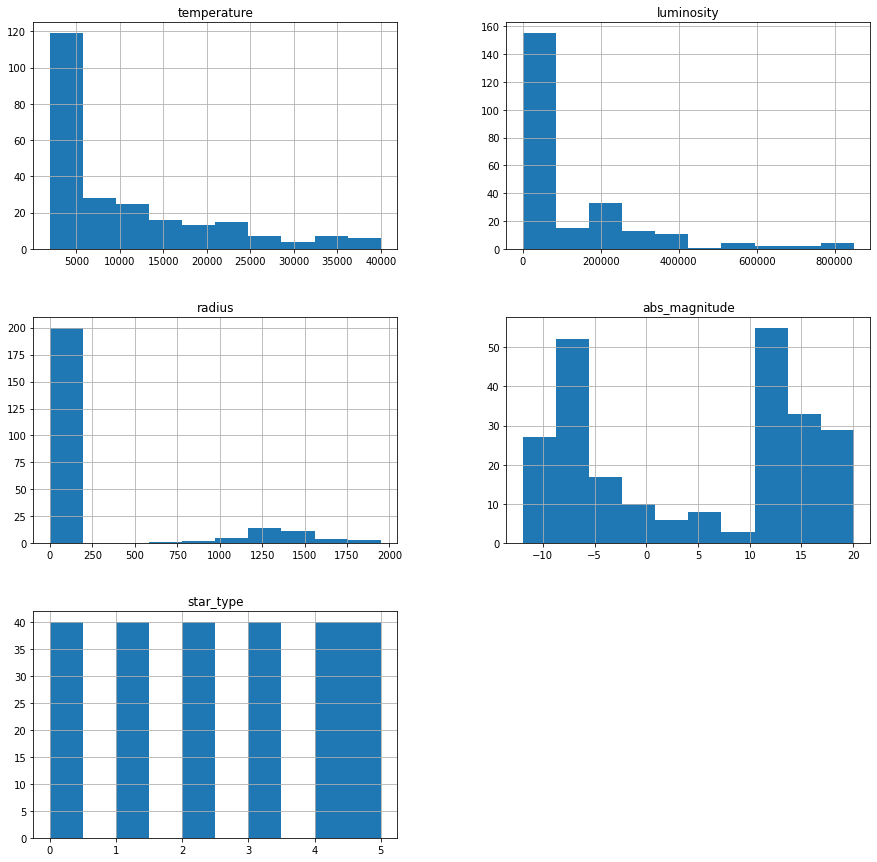

In [13]:
df.hist(figsize=(15, 15))
plt.show()

Что бросается в глаза по графикам:
1) температура и относительная светимость похожи на распределение Пуассона, и это, наверное, естественно для этих данных. 

2) надо проверить относительный радиус на нули.

3) star_type относится к категориальным признакам

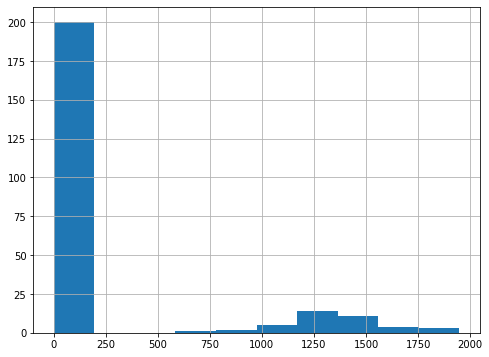

,temperature,luminosity,radius,abs_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.120,0,red
1,3042,0.000500,0.1542,16.600,0,red
2,2600,0.000300,0.1020,18.700,0,red
3,2800,0.000200,0.1600,16.650,0,red
4,1939,0.000138,0.1030,20.060,0,red
...,...,...,...,...,...,...
225,18734,224780.000000,46.0000,-7.450,4,blue
226,9892,593900.000000,80.0000,-7.262,4,blue
227,10930,783930.000000,25.0000,-6.224,4,blue
228,23095,347820.000000,86.0000,-5.905,4,blue


In [14]:
df['radius'].describe()
df['radius'].hist(figsize=(8, 6))
plt.show()
df.query('radius < 250')

In [15]:
df.query('radius > 500')

,temperature,luminosity,radius,abs_magnitude,star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,red
51,3750,283000.0,1260.0,-7.63,5,red
52,3834,272000.0,1183.0,-9.20,5,red
53,3749,550000.0,1648.0,-8.05,5,orange
54,3650,310000.0,1324.0,-7.79,5,red
55,3450,263000.0,1349.0,-11.75,5,red
56,3660,363000.0,1673.0,-11.92,5,red
57,3450,174000.0,1284.0,-11.28,5,red
58,3752,209000.0,955.0,-11.24,5,red
59,3535,195000.0,1546.0,-11.36,5,red


Тайна столбца radius раскрыта. Поскольку данные отображены относительно Солнца, почти половина датасета имеет радиус меньше единицы, т.е. это звезды, которые меньше Солнца. Сорок звезд имеют радиус выше 500, и все они относятся к пятому типу (гипергиганты). Таким образом, данные, похоже, аномалий не представляют.

In [16]:
df['star_type'] = df['star_type'].astype('str') # превращаем столбец в категориальный
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    240 non-null    int64  
 1   luminosity     240 non-null    float64
 2   radius         240 non-null    float64
 3   abs_magnitude  240 non-null    float64
 4   star_type      240 non-null    object 
 5   star_color     240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


Остальные столбцы выглядят адекватно, считаю, что в предобработке не нуждаются. Перейдем к скалированию данных и разбиению на выборки. 

In [17]:
dfc = df.copy()

X = dfc.drop('temperature', axis=1)
y = dfc['temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76767)

In [18]:
enc = OneHotEncoder(handle_unknown='ignore')

ohe_cat = ['star_type', 'star_color']
num_col = ['luminosity', 'radius', 'abs_magnitude']

enc.fit(X_train[ohe_cat])
X_train_coded = pd.DataFrame(enc.transform(X_train[ohe_cat]).toarray(),
                             columns=enc.get_feature_names(ohe_cat),
                            index=X_train.index)

X_test_coded = pd.DataFrame(enc.transform(X_test[ohe_cat]).toarray(),
                             columns=enc.get_feature_names(ohe_cat),
                            index=X_test.index)

In [19]:
scaler = StandardScaler()
scaler.fit(X_train[num_col])
columns = num_col
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_col]), 
                             columns = columns,
                             index = X_train.index)

X_train = pd.concat((X_train_coded, X_train_scaled), axis=1)
                             
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_col]), 
                             columns = columns,
                             index = X_test.index)
                             
X_test = pd.concat((X_test_coded, X_test_scaled), axis=1)

In [20]:
f"Размер обучающей выборки: {X_train.shape}"

'Размер обучающей выборки: (192, 16)'

In [21]:
f"Размер тестовой  выборки: {X_test.shape}"

'Размер тестовой  выборки: (48, 16)'

In [22]:
X_train

,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue,star_color_blue-white,star_color_orange,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white,luminosity,radius,abs_magnitude
95,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.589408,-0.436263,-0.622865
59,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.450058,2.630190,-1.491932
104,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006089,-0.426260,-0.969149
176,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476803,1.631962,-1.198406
183,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.593003,-0.449973,1.261072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.593003,-0.449917,1.249562
143,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.593003,-0.450151,0.741167
169,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.677768,-0.402351,-0.976823
208,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.593003,-0.450149,0.716227


In [23]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [24]:
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [25]:
X_train.size()
y_train.size()
X_test.size()
y_test.size()

torch.Size([48, 1])

На этом этапе мы провели кодирование категориальных признаков, разбиение на тренировочную и тестовую выборки, масштабирование количественных признаков. Предобработка окончена, можно приступать к построению нейронной сети.

## Построение базовой нейронной сети

In [24]:
# Гиперпараметры обучения:
# '''
# torch.manual_seed(1234)
# input_size = 28*28
# hidden_size = 550
# num_classes = 10
# num_epochs = 1
# batch_size = 100
# learning_rate = 0.001

In [25]:
torch.manual_seed(76767)
np.random.seed(76767)

In [26]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 200
n_hidden_neurons_2 = 300
n_out_neurons = 1

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.ReLU()
)

optimizer = torch.optim.Adam(net.parameters(), lr=0.003) 

loss = nn.MSELoss()

num_epochs = 500

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = torch.sqrt(loss(preds, y_train.flatten()))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 50 == 0 or num_epochs / epoch == 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        rmse = torch.sqrt(loss(test_preds, y_test.flatten()))
        
        print(rmse)

tensor(11851.1045, grad_fn=<SqrtBackward0>)
tensor(11265.9668, grad_fn=<SqrtBackward0>)
tensor(7485.7974, grad_fn=<SqrtBackward0>)
tensor(4886.9971, grad_fn=<SqrtBackward0>)
tensor(4141.8296, grad_fn=<SqrtBackward0>)
tensor(3816.1558, grad_fn=<SqrtBackward0>)
tensor(3768.5042, grad_fn=<SqrtBackward0>)
tensor(3727.4211, grad_fn=<SqrtBackward0>)
tensor(3658.7227, grad_fn=<SqrtBackward0>)
tensor(3589.0471, grad_fn=<SqrtBackward0>)


In [27]:
test_preds

tensor([ 5364.8462, 18133.4121, 18595.7559, 20681.0020,  6011.1523, 19355.8438,
         2984.2578,  3095.7329,  3343.9497,  2743.6143,  3118.2415,  3730.8530,
         3188.5693,  3067.7942,  3355.8987,  2938.2266,  3110.1885, 14094.2383,
         3004.4465,  2898.4360,  3307.2278,  7237.5786,  2611.1821,  4502.0322,
        19120.1797, 18146.7305,  7764.3418,  3092.9883,  7086.2661, 18742.2148,
         3349.6155, 20208.9219,  2851.0376, 18476.2812, 21206.6777,  3005.7700,
         2955.4421,  2950.0496, 12398.5684, 17318.9980, 10123.5020,  3133.1436,
         3011.1355, 18915.2344,  3016.7234,  9093.8203, 20197.5918, 11966.6816],
       grad_fn=<ReshapeAliasBackward0>)

In [30]:
def draw_plot(target, preds, width = 0.4):
    y1 = target.numpy().reshape([-1])
    y2 = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y1))
    fig,ax = plt.subplots()
    rects1 = ax.bar(x, y1, width, label = 'Факт', color = 'darkblue')
    rects2 = ax.bar(x, y2, width/3, label = 'Прогноз', color = 'limegreen')
    ax.set_title('Факт - Прогноз')
    ax.set_xticks(x)
    ax.set_xlabel('Номер')
    ax.set_ylabel('Температура')
    fig.set_figwidth(20)
    fig.set_figheight(10)
    ax.legend();

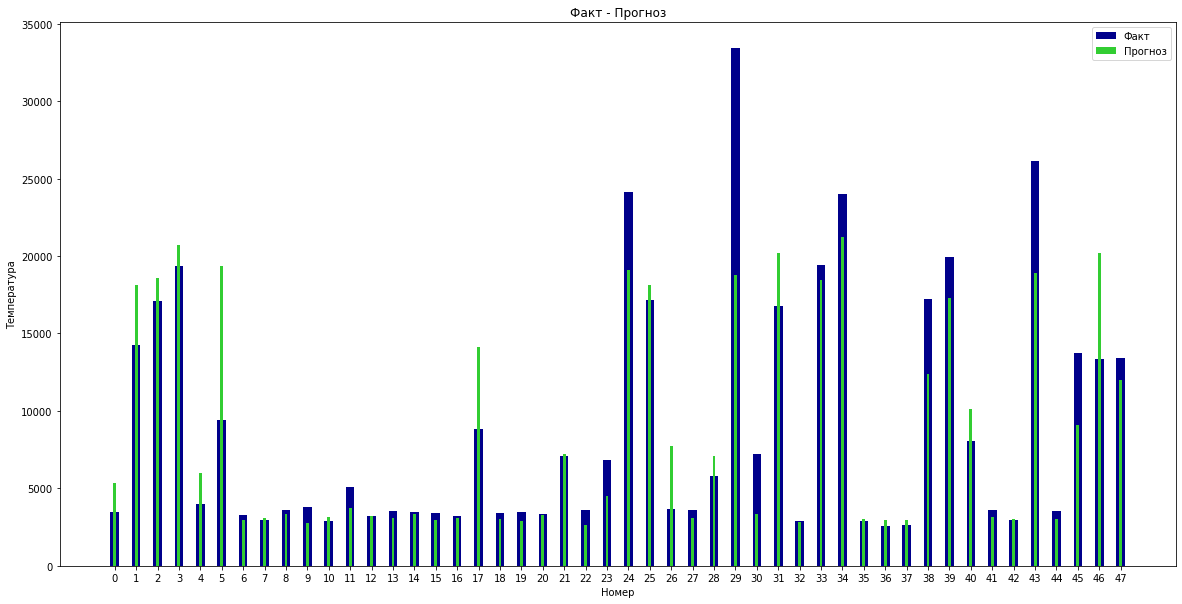

In [31]:
draw_plot(y_test, test_preds)

Бейзлайн-модель готова. Выдает метрику RMSE в районе 3600, что уже лучше таргета в 4500. 

Модель довольно точно предсказывает невысокую температуру. Часто ошибается на температуре от 10000 К, возможно, потому, что звезд с такой температурой меньше и потому их тяжелее "просчитать" для нейронной сети.

## Улучшение нейронной сети

Попробуем улучшить нейросеть с помощью BatchNormalization.

In [35]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 200
n_hidden_neurons_2 = 300
n_out_neurons = 1

net_bn = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.ReLU()
)

optimizer = torch.optim.Adam(net_bn.parameters(), lr=0.003) 

loss = nn.MSELoss()

num_epochs = 2000

for epoch in range(num_epochs):
    net_bn.train()
    optimizer.zero_grad()
    preds = net_bn.forward(X_train).flatten()
    loss_value = torch.sqrt(loss(preds, y_train.flatten()))
    loss_value.backward()
    optimizer.step()
    
    if epoch % 200 == 0 or num_epochs / epoch == 1:
        with torch.no_grad():
            net_bn.eval()
            bn_test_preds = net_bn.forward(X_test).flatten()
            rmse = torch.sqrt(loss(bn_test_preds, y_test.flatten()))
            print(rmse)

tensor(11851.3301)
tensor(11566.5830)
tensor(10819.1914)
tensor(9323.6250)
tensor(7618.3652)
tensor(5671.9814)
tensor(4233.7876)
tensor(4065.4204)
tensor(4059.5615)
tensor(4294.0762)


In [33]:
bn_test_preds

tensor([ 3816.7705, 31793.8926, 12279.0186, 18083.1660,  3700.7600, 19923.5820,
         3051.7092,  3162.8945,  4151.9790,  3368.5046,  3311.5073,     0.0000,
         3337.9324,  3136.2471,  3443.4231,  3027.5913,  3312.0039, 16478.4258,
         3073.6160,  3839.1438,  3407.7344,  8012.4502,  3407.8625,  3782.2554,
        23503.9121, 11291.6494,  3925.5286,  3313.7603,  5144.9507, 25288.3379,
            0.0000, 17917.7168,  3002.1477, 21844.9883, 21276.8418,  3074.6299,
         3032.4153,  3030.9329, 12407.8555, 19563.8281,  5178.4097,  3660.0642,
         3080.3298, 23009.1895,  3313.0427, 14467.9355, 18026.5566,  9665.5615])

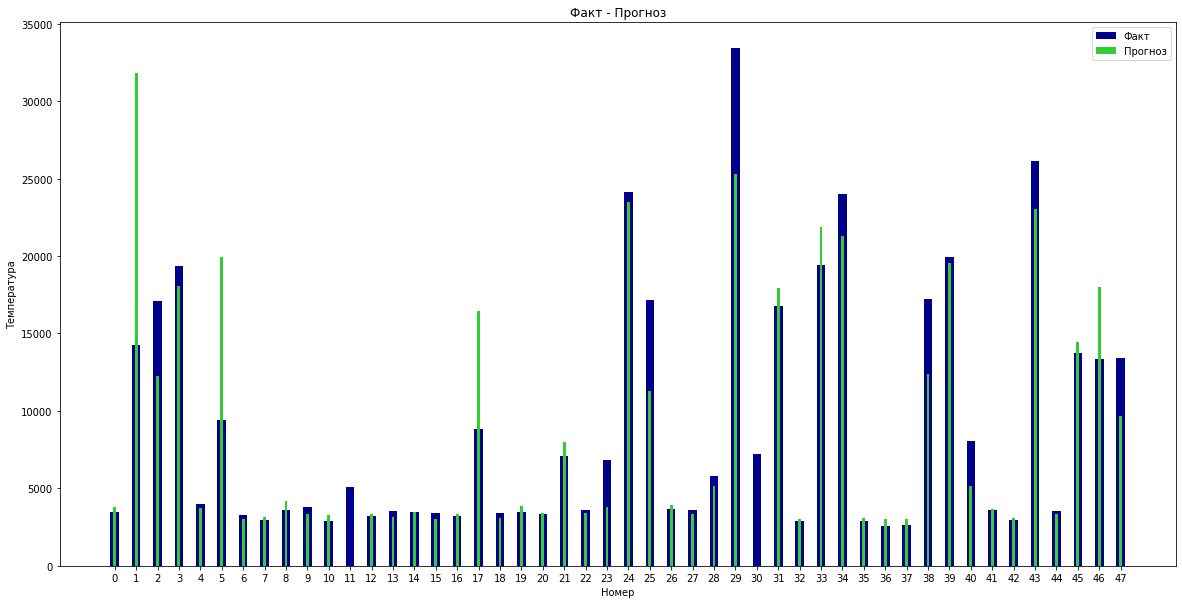

In [34]:
draw_plot(y_test, bn_test_preds)

Batch Normalization работает только при увеличении количества эпох в 4 раза, но метрики хуже, чем без неё. 

Теперь попробуем Dropout. Значения будем перебирать циклом из списка ниже.

In [36]:
dropout_values = [0.1, 0.3, 0.5, 0.7]

In [37]:
for value in dropout_values:
    net_dp = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Dropout(p=value),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Dropout(p=value),
        nn.Linear(n_hidden_neurons_2, n_out_neurons), 
        nn.ReLU()
    )
    
    optimizer = torch.optim.Adam(net_dp.parameters(), lr=0.003) 

    loss = nn.MSELoss()

    num_epochs = 500

    for epoch in range(num_epochs):
        net_dp.train()
        optimizer.zero_grad()
        preds = net_dp.forward(X_train).flatten()
        loss_value = torch.sqrt(loss(preds, y_train.flatten()))
        loss_value.backward()
        optimizer.step()
    
        if epoch % 50 == 0 or num_epochs / epoch == 1:
            with torch.no_grad():
                net_dp.eval()
                dp_test_preds = net_dp.forward(X_test).flatten()
                rmse = torch.sqrt(loss(dp_test_preds, y_test.flatten()))
        
    print(f'dropout_value: {value}, rmse: {rmse}')        

dropout_value: 0.1, rmse: 3607.3505859375
dropout_value: 0.3, rmse: 3632.937744140625
dropout_value: 0.5, rmse: 3738.780517578125
dropout_value: 0.7, rmse: 3759.9736328125


In [38]:
dp_test_preds

tensor([ 6143.2979, 18125.6777, 18384.6582, 21201.9355,  6591.7769, 19443.8262,
         2835.3918,  2881.2378,  4500.1597,  1398.9146,  3051.6614,  4027.7615,
         3089.0388,  2869.7161,  3175.6768,  2816.4878,  3047.4082, 15568.0908,
         2843.6147,  3759.2959,  3150.4204,  6368.3193,  1794.6224,  5375.0859,
        18619.8809, 17831.9453,  8096.0234,  3037.7783,  7597.6797, 19172.8047,
         3508.3284, 20820.6602,  2779.9944, 18066.9844, 21537.1426,  2844.2732,
         2823.5977,  2821.3650, 12157.3125, 17213.0781, 10802.1670,  4006.4968,
         2846.4822, 18328.7988,  2997.5005,  8513.8135, 20811.6348, 11856.0879])

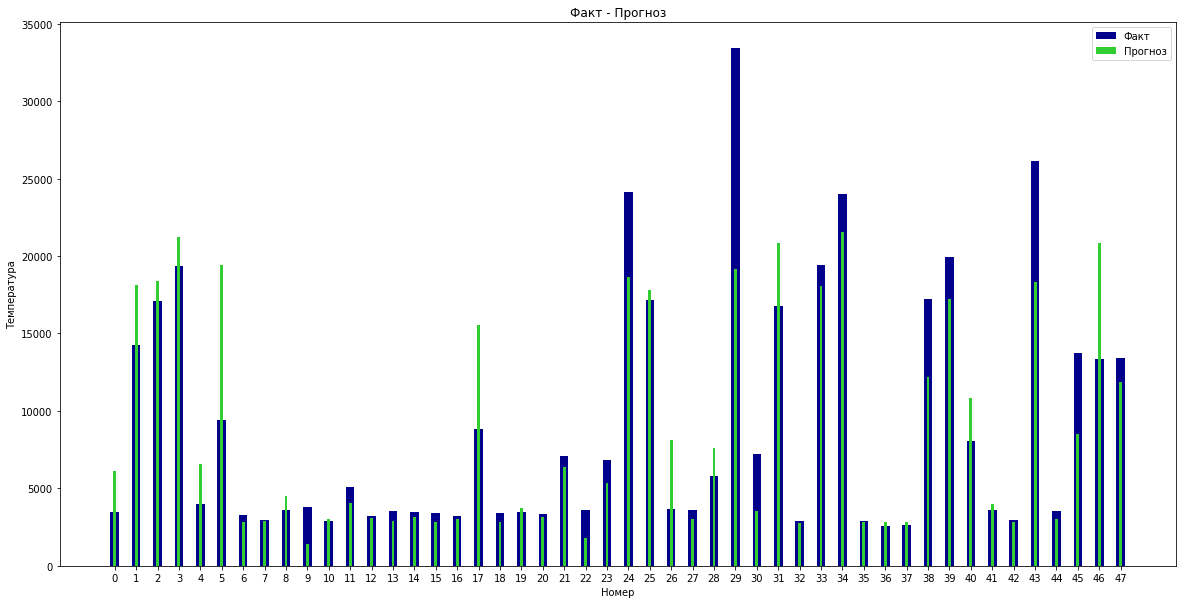

In [39]:
draw_plot(y_test, dp_test_preds)

## Выводы

Улучшения метрики RMSE получить с помощью Dropout и BatchNorm не удалось. BatchNorm превосходил baseline только с увеличением количества эпох в 4 раза.

Кажется, удалось собрать слишком удачный бейэлайн (RMSE = 3589) :)